# Simulation Methodology for Electron Transfer in CMOS Quantum Dots
## Eigenenergy and Eigenfunction Calculation Using the Matrix Diagonalisation Method
### Dmytro Mishagli
This Notebook contains the code to reproduce some results shown in the paper _Simulation Methodology for Electron Transfer in CMOS Quantum Dots_ by A. Sokolov, D. Mishagli, P. Giounanlis, I. Bashir, D. Leipold, E. Koskin,
R.B. Staszewski and E. Blokhina

In [1]:
from qsol import basis, integ, get_solution
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

## How fast does the solution converge to the actual one?
## Double-Well Ground State Example

Examine the convergence with increase of the number of basis functions.

In [2]:
# Get another fonts
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist]);

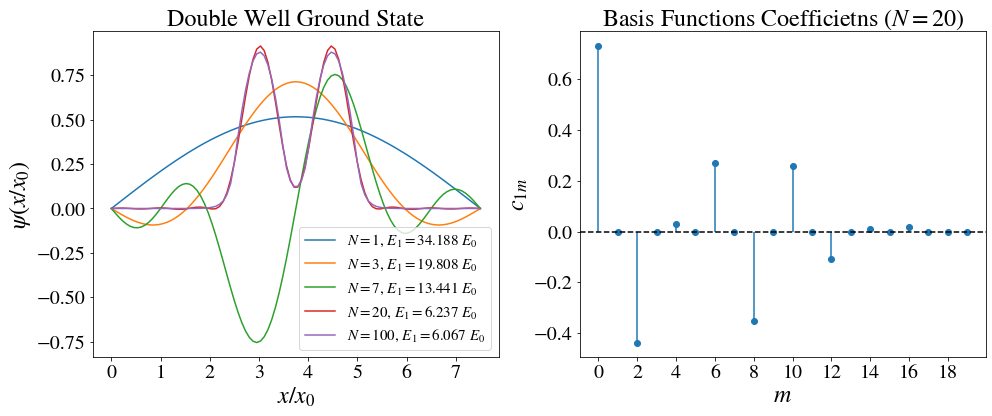

In [3]:
# list with the numbers of basis functions
bfuns = [1, 3, 7, 20, 100]

# parameters of the double well
Vext = [70,70]
Vint = [50]
wells = [ 1, 1 ] 
barriers = [ 0.5 ]

# size of shift from 0
h = np.sum(wells) + np.sum(barriers)
# width of an infinite square well
L = 3*h

# create a figure
fig = plt.figure(figsize=(16,6))

xdata = np.linspace(0,L,100)

plt.subplot(121)
for bf in bfuns:
    energies, eigvecs = get_solution(Vext,Vint,wells,barriers,bf)
    psi = lambda x,energy: np.dot( eigvecs[energy], [basis(x,n,L) for n in range(1,bf+1)] )
    plt.plot(xdata,psi(xdata,0),label="$N=$%s, $E_1=$%.3f $E_0$" % (bf,energies[0]))

plt.legend(fontsize=15)
plt.title('Double Well Ground State', fontsize = 24)
plt.xlabel('$x/x_0$', fontsize = 24)
plt.ylabel("$\psi(x/x_0)$", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

n_bas_func = 20
energies, eigvecs = get_solution(Vext,Vint,wells,barriers,n_bas_func)

plt.subplot(122)

p = plt.plot(eigvecs[0],'o')
c = p[0].get_color()
for m,point in enumerate(eigvecs[0]):
    plt.vlines(m,0,point,c)

# dashed horizontal line at x=0
plt.axhline(0,ls='--',c='k')

plt.title('Basis Functions Coefficietns ($N=%s$)' % n_bas_func, fontsize = 24)
plt.xlabel('$m$', fontsize = 24)
plt.ylabel("$c_{1m}$", fontsize = 24)
plt.xticks(np.arange(0, n_bas_func, step=2),fontsize=20)
_ = plt.yticks(fontsize=20)

# fig.savefig('2well_ground_state_basis_functions.pdf', format='pdf', bbox_inches="tight")

We can see, that having only $N=20$ basis functions we already obtain good approximation.

## COMSOL Potential

Min value is -28.871529860473476


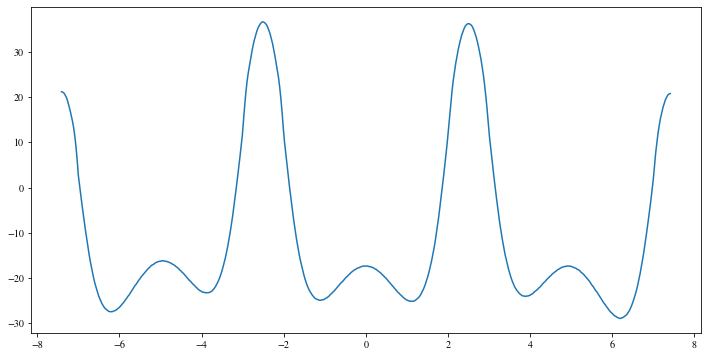

In [4]:
import pandas as pd
from io import StringIO

data = pd.read_csv('potential_points_V1_295mV_V2_295_mV.dat',delimiter = '\t')

xdata = data.values.T[0][2:-3]
ydata = data.values.T[1][2:-3]
v_shift = np.abs(min(ydata))
print("Min value is", - v_shift)

fig = plt.figure(figsize=(12,6))
_ = plt.plot(xdata,ydata)

# fig.savefig("potential_profile.svg" , format='svg', bbox_inches="tight")

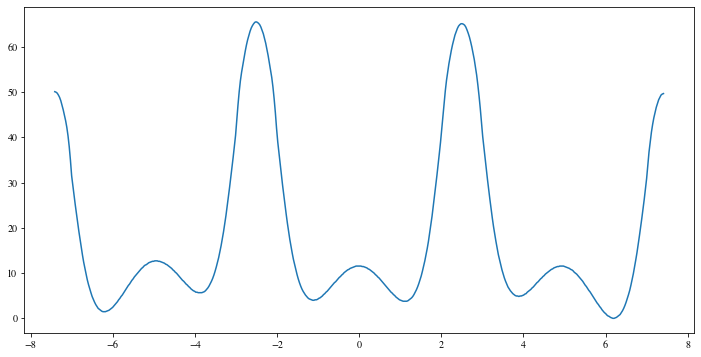

In [5]:
# shift the potential
ydata = ydata + v_shift

fig = plt.figure(figsize=(12,6))

_ = plt.plot(xdata,ydata)

The energy-dimension coefficient:

In [6]:
m = 1.09 * 9.10938188e-31
a = 20e-9

hbar = 6.58211957e-16
eV = 1.60276634e-19

# (!) note: 2 from the Schoedinger's operator is kept here
coef = (hbar**2*eV) / (2 * a**2 * m) 

print('Energy unit is %.2e eV' % coef)

Energy unit is 8.74e-05 eV


In [7]:
from scipy.interpolate import InterpolatedUnivariateSpline

def potential_COMSOL(n,m,Vext,xdata,ydata):
    '''
    Function returns the value of Vnm, matrix element of a potential
    
    Vext - list, left and right (exterior) potential wells' heights
    xdata - array, x-values for the potential
    ydata - array, y-values of the potential
    '''
    # size of shift from 0
    h = np.abs(xdata[0]-xdata[-1])
    # width of an infinite square well
    L = 3*h
    # shift the data by h
    xdata = xdata+h
    
    # generate the data for basis functions
    basis_ndata = basis(xdata,n,L)
    basis_mdata = basis(xdata,m,L)
    
    # interpolate with a spline
    f = InterpolatedUnivariateSpline(xdata, basis_ndata*ydata*basis_mdata, k=1)
    # calculate the interral
    s = f.integral(h, L-h)
    
    return Vext[0]*integ(n, m, 0, h, L) + Vext[1]*integ(n, m, L-h, L, L) + s

In [8]:
Vext = 2*[max(ydata)]
Vext

[65.51212593794719, 65.51212593794719]

In [9]:
# number of basis functions
num_bas_funs = 320

# length of the potential
h = np.abs(xdata[0]-xdata[-1])
# we need to shift potential to fit the infitie potential well
shift = h/2 # this shifts potential to [0,h]

# width of the infinite potential well
L = 3*h

# exterior potential well's heights
Vext = [max(ydata), max(ydata)]

# get the Vnm matrix
potential_matrix = [[potential_COMSOL(n,m,Vext,xdata+shift,ydata) for n in range(1,num_bas_funs+1)] for m in range(1,num_bas_funs+1)]

# (!) note: there is no 2 in front of L
evalues = [n**2*np.pi**2/(L**2) for n in range(1,num_bas_funs+1)]
# create a diagonal matrix
H0 = np.diag(evalues)
# get solution
eigvals, eigvecs = np.linalg.eigh(H0+potential_matrix)

# bound states are below the exterior height
eigvals = eigvals[eigvals<min(Vext)]
# transopse the matrix with eigenvectors (we need rows)
# and left only those who correspond to the bound states
eigvecs = eigvecs.T[:len(eigvals)]

print("The length of the infinite potential wells is L = %s." % L)
print("\nThere are %s bounded states." % len(eigvals))
print("They are:\n",eigvals)

The length of the infinite potential wells is L = 44.47200000000001.

There are 32 bounded states.
They are:
 [ 5.0949958   6.47324446  8.05145011  8.72254604  9.17824721 10.01771438
 13.07548448 14.26189838 14.37229482 17.51472028 18.54428364 18.71053768
 23.0986992  24.14044016 24.61913437 29.42726896 30.43547686 31.17150637
 36.29957757 37.28870379 38.30422917 43.5311348  44.48068201 45.83097634
 50.87799512 51.78536317 53.52453844 58.02553671 58.83683984 61.04528632
 64.47118847 65.15644555]


The eigenvalues for non-shifted potential:

In [10]:
print("They are:\n",eigvals-v_shift)

They are:
 [-23.77653406 -22.3982854  -20.82007975 -20.14898382 -19.69328265
 -18.85381548 -15.79604538 -14.60963148 -14.49923504 -11.35680958
 -10.32724622 -10.16099218  -5.77283066  -4.7310897   -4.25239549
   0.5557391    1.563947     2.2999765    7.4280477    8.41717393
   9.43269931  14.65960494  15.60915215  16.95944647  22.00646526
  22.91383331  24.65300858  29.15400685  29.96530998  32.17375646
  35.59965861  36.28491569]


Potential is located between [14.8,29.6]


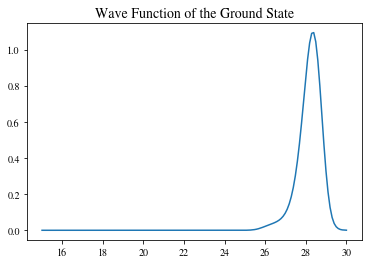

In [11]:
L1 = L
psi = lambda x,energy: np.dot( eigvecs[energy], [basis(x,n,L1) for n in range(1,num_bas_funs+1)] )

wave_funs = []
wave_funs.append(psi)

x = np.linspace(15,30,150)

print("Potential is located between [%.1f,%.1f]" % (h,L-h) )

# number of energy level
en = 1
# plot the wave function
plt.plot(x,psi(x,en-1))
plt.title("Wave Function of the Ground State", fontsize=(14));

Plot the energy scpectrum and the first 6 wave functions

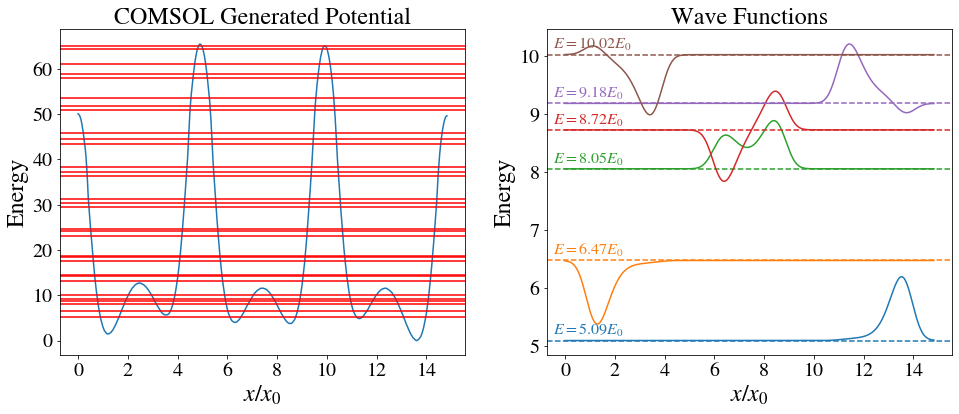

In [15]:
#
fig = plt.figure(figsize=(16,6))

# left plot
plt.subplot(121)

plt.plot(xdata+shift,ydata)
for en in eigvals:
    plt.axhline(en, c='r')
# add title
plt.title('COMSOL Generated Potential',fontsize=24)
# set y-axes labels and ticks size
plt.ylabel("Energy", fontsize = 24)
plt.yticks(fontsize=13)
# set x-axes labels and ticks size
plt.xlabel('$x/x_0$', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# right plot
plt.subplot(122)
# plt.plot(xdata+shift,ydata)

x = np.linspace(h,L-h,500)
# psi = lambda x,energy: np.dot( eigvecs[energy], [basis(x,n,L) for n in range(1,num_bas_funs+1)] )

for i,en in enumerate(eigvals[:6]):
    yplot = psi(x,i)
    curve = plt.plot(x-2*shift, yplot+en)
    col = curve[0].get_color()
    plt.axhline(en, ls="--", c=col)
    plt.text(-0.5, en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)

# plt.legend(fontsize=15)
plt.title('Wave Functions', fontsize = 24)
plt.xlabel('$x/x_0$', fontsize = 24)
plt.ylabel("Energy", fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# fig.savefig('comsol_potential_spectrum.pdf', format='pdf', bbox_inches="tight")

The energies of the first 6 levels in eV:

In [16]:
eigvals[:6]*coef

array([0.00044539, 0.00056587, 0.00070383, 0.0007625 , 0.00080234,
       0.00087572])

The difference between two lowest energies:

In [17]:
(eigvals[1]-eigvals[0])*coef

0.00012048248974101458

## Square-well Approximation

In [18]:
def piecewise(x,Vext,Vint,widths):
    if np.iterable(x):
        return np.array([piecewise(xi,Vext,Vint,widths) for xi in x])
    elif x <= 0:
        return Vext[0]
    elif x >= sum(widths):
        return Vext[1]
    else:
        for i in range( len(widths) ):
            if x >= sum(widths[:i]) and x <= sum(widths[:i+1]):
                return Vint[i]

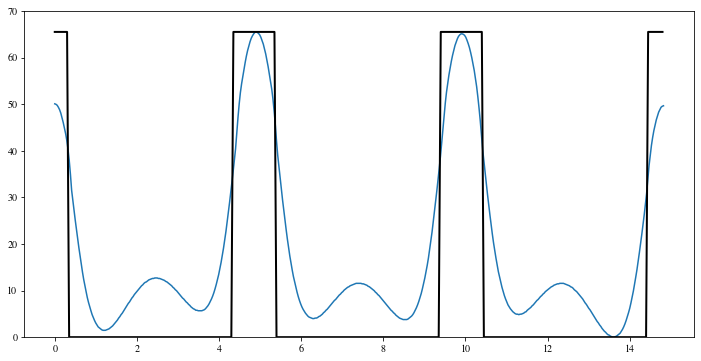

In [19]:
# Vext_1 = [200, 200]
# Vint_1 =   [200, 0,  65, 0,  65, 0,  200]
# widths_1 = [0.35, 4, 1.05, 4, 1.05, 4, 0.35]

Vext_1 = 2 * [max(ydata)]
Vint_1 = [max(ydata), 0,  max(ydata), 0,  max(ydata), 0,  max(ydata)]
widths_1 = [0.35, 4, 1.05, 4, 1.05, 4, 0.35]

# print( sum(widths) )
# print(h)

fig = plt.figure(figsize=(12,6))

plt.plot(xdata+shift,ydata)
pylab.ylim([0,70])

xx = np.arange(0,xdata[-1]+shift,0.05)
_ = plt.plot(xx,piecewise(xx,Vext_1,Vint_1,widths_1),c='k',linewidth=2.0)

In [20]:
def integ(n,m,lower_limit,upper_limit,L):
    """
    Returns values of the integrals in a Hamiltonian of a square potential well,
    calculated analytically
    """
    alpha = n*np.pi/L
    beta  = m*np.pi/L

    if n!=m:
        f = lambda x: 0.5 * ( np.sin((alpha-beta)*x)/(alpha-beta) - np.sin((alpha+beta)*x)/(alpha+beta) )
        return 2/L * (f(upper_limit) - f(lower_limit))
    else:
        f = lambda x: 0.5 * ( x - np.sin((alpha+beta)*x)/(alpha+beta) )
        return 2/L * (f(upper_limit) - f(lower_limit))
    
def Vnm_piecewise(n,m,Vext,Vint,widths):
    '''
    Vext - list, left and right (exterior) potential wells' heights
    Vint - list, interatomic wells heights
    widths - list, iterior wells' widths
    '''
    h = sum(widths)
    L = 3*h
    s = 0
    for i in range(len(widths)):
        s += Vint[i] * integ( n,m, h+sum(widths[:i]), h+sum(widths[:i+1]), L )
    return Vext[0]*integ(n, m, 0, h, L) + Vext[1]*integ(n, m, L-h, L, L) + s

In [21]:
# size of shift from 0
h = np.sum(widths_1)
# width of an infinite square well
L = 3*h

num_bas_funs_1 = 400

potential_matrix = [[Vnm_piecewise(n,m,Vext_1,Vint_1,widths_1) for n in range(1,num_bas_funs_1+1)] for m in range(1,num_bas_funs_1+1)]
# compute a list of eigenvalues for H0
evalues = [n**2*np.pi**2/(L**2) for n in range(1,num_bas_funs_1+1)]
# create a diagonal matrix
H0 = np.diag(evalues)
# get solution
eigvals_approx, eigvecs_approx = np.linalg.eigh(H0+potential_matrix)

# bound states are below the exterior height
eigvals_approx = eigvals_approx[eigvals_approx<max(Vext_1)]
# transopse the matrix with eigenvectors (we need rows)
# and left only those who correspond to the bound states
eigvecs_approx = eigvecs_approx.T[:len(eigvals_approx)]

print("The length of the infinite potential wells is L = %s." % L)
print("\nThere are %s bounded states." % len(eigvals_approx))
print("They are:\n",eigvals_approx)

The length of the infinite potential wells is L = 44.4.

There are 33 bounded states.
They are:
 [ 0.54719847  0.54722448  0.54724971  2.187683    2.18783237  2.18797343
  4.91812856  4.91841229  4.91868906  8.73228229  8.73303985  8.73376259
 13.62081353 13.62202561 13.62321863 19.56850435 19.57128914 19.57398972
 26.5531805  26.55826835 26.56332405 34.53567671 34.54783345 34.55984758
 43.44610895 43.47537563 43.50481647 53.11385305 53.20274095 53.29421848
 62.93980212 63.24369064 63.62972976]


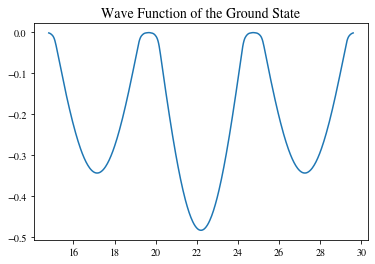

In [22]:
L2 = L

psi_approx = lambda x,energy: np.dot( eigvecs_approx[energy], [basis(x,n,L2) for n in range(1,num_bas_funs_1+1)] )

wave_funs.append(psi_approx)

# x = np.linspace(h,L-h,511)
x = np.linspace(h,L-h,500)

# number of energy level
en = 1
# plot the wave function
plt.plot(x,psi_approx(x,en-1))
_ = plt.title("Wave Function of the Ground State", fontsize=(14))

The energies of the first 6 levels in eV:

In [23]:
eigvals_approx[:6]

array([0.54719847, 0.54722448, 0.54724971, 2.187683  , 2.18783237,
       2.18797343])

The difference between two lowest energies:

In [24]:
(eigvals_approx[1]-eigvals_approx[0])*coef

2.27380933946632e-09

Plot the energy scpectrum and the first 6 wave functions:

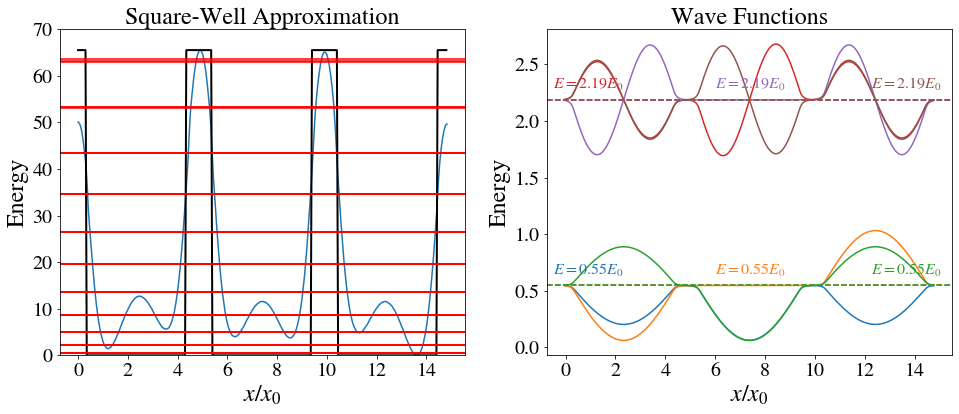

In [25]:
fig2 = plt.figure(figsize=(16,6))

# left plot
plt.subplot(121)

plt.plot(xdata+shift,ydata)
plt.plot(xx,piecewise(xx,Vext_1,Vint_1,widths_1),c='k',linewidth=2.0)
pylab.ylim([0,70])
for en in eigvals_approx:
    plt.axhline(en, c='r')
# add title
plt.title('Square-Well Approximation',fontsize=24)
# set y-axes labels and ticks size
plt.ylabel("Energy", fontsize = 24)
plt.yticks(fontsize=13)
# set x-axes labels and ticks size
plt.xlabel('$x/x_0$', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# right plot
plt.subplot(122)
# plt.plot(xdata+shift,ydata)

x = np.linspace(h,L-h,500)
# psi = lambda x,energy: np.dot( eigvecs_approx[energy], [basis(x,n,L) for n in range(1,num_bas_fun+1)] )

text_location = [ -0.5, 6, 12.25, -0.5, 6, 12.25]
for i,en in enumerate(eigvals_approx[:6]):
    yplot = psi_approx(x,i)
    curve = plt.plot(x-2*shift, yplot+en)
    col = curve[0].get_color()
    plt.axhline(en, ls="--", c=col)
    plt.text(text_location[i], en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)
#     plt.text(-0.5, en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)


# plt.legend(fontsize=15)
plt.title('Wave Functions', fontsize = 24)
plt.xlabel('$x/x_0$', fontsize = 24)
plt.ylabel("Energy", fontsize = 24)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

# fig2.savefig('200-square-well_approx_potential_spectrum.pdf', format='pdf', bbox_inches="tight")

## More Accurate Piecewise Approximation
Let us take into account all the peculiarities of the potential. To do this, we shall find the locations of extrema of the potential functions first.

In [26]:
def get_loc_of_min(xdata,ydata,a,b):
    # get the location of a minumum im the interval [a,b]
    loc_of_min = np.array(np.where( ydata == ydata[a:b].min() )).flatten()
    loc_of_min = [ x for x in list(loc_of_min) if x>a and x<b ] # keep only locations within [a,b]
    print('array with locations:',loc_of_min)
    if len(loc_of_min)==3:
        loc_of_min = loc_of_min[1]     # take the middle one
    elif len(loc_of_min)>1:
        # there are three equal values
        loc_of_min = loc_of_min[ len(loc_of_min)//2 ]
    else: loc_of_min = loc_of_min[0]
    
    return loc_of_min, ydata[loc_of_min]


In [27]:
x1, v1 = get_loc_of_min(xdata,ydata,25,75)
print( "V(xdata[%s]) = %.3f" % (x1,v1) )

array with locations: [40, 41, 42]
V(xdata[41]) = 1.470


In [28]:
def get_loc_of_max(xdata,ydata,a,b):
    # get the location of a minumum im the interval [a,b]
    loc_of_max = np.array(np.where( ydata == ydata[a:b].max() )).flatten()
    loc_of_max = [ x for x in list(loc_of_max) if x>a and x<b ] # keep only locations within [a,b]
    print('array with locations:',loc_of_max)
    if len(loc_of_max)==3:
        # there are three equal values
        loc_of_max = loc_of_max[1]
    elif len(loc_of_max)>1:
        # there are more than 1 but not 3 values
        loc_of_max = loc_of_max[ len(loc_of_max)//2 ]
    else: loc_of_max = loc_of_max[0]
    
    return loc_of_max, ydata[loc_of_max]

In [29]:
x2, v2 = get_loc_of_max(xdata,ydata,75,100)
print( "V(xdata[%s]) = %.3f" % (x2,v2) )

array with locations: [83, 84, 85]
V(xdata[84]) = 12.703


In [30]:
x3, v3 = get_loc_of_min(xdata,ydata,100,135)
print( "V(xdata[%s]) = %.3f" % (x3,v3) )

array with locations: [119, 120, 121, 122]
V(xdata[121]) = 5.669


The location of the left _big_ maximum, $V_0^{(1)}$:

In [31]:
x01, v01 = get_loc_of_max(xdata,ydata,155,175)
print( "V(xdata[%s]) = %.3f" % (x01,v01) )

array with locations: [167]
V(xdata[167]) = 65.512


In [32]:
x4, v4 = get_loc_of_min(xdata,ydata,200,235)
print( "V(xdata[%s]) = %.3f" % (x4,v4) )

array with locations: [214, 215]
V(xdata[215]) = 3.990


In [33]:
x5, v5 = get_loc_of_max(xdata,ydata,235,265)
print( "V(xdata[%s]) = %.3f" % (x5,v5) )

array with locations: [250, 251, 252, 253, 254]
V(xdata[252]) = 11.549


In [34]:
x6, v6 = get_loc_of_min(xdata,ydata,280,300)
print( "V(xdata[%s]) = %.3f" % (x6,v6) )

array with locations: [289, 290, 291, 292]
V(xdata[291]) = 3.780


The location of the right _big_ maximum, $V_0^{(2)}$:

In [35]:
x02, v02 = get_loc_of_max(xdata,ydata,300,360)
print( "V(xdata[%s]) = %.3f" % (x02,v02) )

array with locations: [337, 338]
V(xdata[338]) = 65.092


In [36]:
x7, v7 = get_loc_of_min(xdata,ydata,380,400)
print( "V(xdata[%s]) = %.3f" % (x7,v7) )

array with locations: [385]
V(xdata[385]) = 4.829


In [37]:
x8, v8 = get_loc_of_max(xdata,ydata,400,440)
print( "V(xdata[%s]) = %.3f" % (x8,v8) )

array with locations: [419, 420, 421, 422]
V(xdata[421]) = 11.549


In [38]:
x9, v9 = get_loc_of_min(xdata,ydata,440,480)
print( "V(xdata[%s]) = %.3f" % (x9,v9) )

array with locations: [463, 464]
V(xdata[464]) = 0.000


Collect the results and build a piecewise approximation:

In [39]:
Vint   =    [ v1,v2,v3,v01,v4,v5,v6,v02,v7,v8,v9 ]
locations = [ x1,x2,x3,x01,x4,x5,x6,x02,x7,x8,x9 ]

In [40]:
# add left and right (surrounding) heights to the potential
Vint.insert(0,max(Vint))
Vint.append(max(Vint))
print('The heights of potential barriers in the picewise approximation:\n',np.round(Vint,2))

The heights of potential barriers in the picewise approximation:
 [65.51  1.47 12.7   5.67 65.51  3.99 11.55  3.78 65.09  4.83 11.55  0.
 65.51]


In [41]:
# an external well
Vext = 2 * [max(Vint)]
Vext

[65.51212593794719, 65.51212593794719]

Now, knowing the locations (indeces) of maxima (minima) in the data set _xdata_, we can obtain the coordinates for piceweise potential's shelves. The shelves are to be located between the half distances of the extrema points.

In [42]:
# find the coordinates of begin and end points for the shelves
coordinates = [ xdata[i]+shift+(xdata[j]-xdata[i])/2 for i,j in zip(locations[:-1],locations[1:]) ]
first = xdata[0] + (xdata[locations[0]] - xdata[0])/2 + shift
last  = xdata[locations[-1]] + (xdata[-1] - xdata[locations[-1]])/2 + shift
coordinates.insert(0,first)
coordinates.append(last)
coordinates

[0.6017500000000009,
 1.83475,
 3.0090000000000003,
 4.227000000000001,
 5.606500000000001,
 6.85425,
 7.969750000000001,
 9.232000000000001,
 10.61175,
 11.82975,
 12.989250000000002,
 14.222250000000003]

Finally, from the coordinates we obtain the shelves' lengths.

In [43]:
widths = [j-i for i,j in zip(coordinates[:-1],coordinates[1:])]
widths.insert(0,coordinates[0])
widths.append(xdata[-1]+shift-coordinates[-1])
print('The widths of shelves in the picewise approximation:\n',np.round(widths,2))

The widths of shelves in the picewise approximation:
 [0.6  1.23 1.17 1.22 1.38 1.25 1.12 1.26 1.38 1.22 1.16 1.23 0.6 ]


In [44]:
# check if the number of shelves and their widths are the same
len(Vint) == len(widths)

True

In [45]:
Vint_2 = Vint
Vext_2 = Vext
widths_2 = widths

Finally, the accurate piecwise approximation looks as follows:

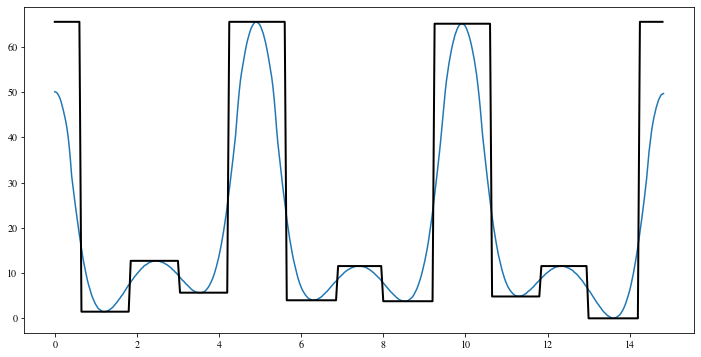

In [46]:
fig = plt.figure(figsize=(12,6))

plt.plot(xdata+shift,ydata)
_ = plt.plot(xx,piecewise(xx,Vext_2,Vint_2,widths_2),c='k',linewidth=2.0)

In [47]:
# size of shift from 0
h = np.sum(widths_2)
# width of an infinite square well
L = 3*h

num_bas_funs_2 = 400

potential_matrix = [[Vnm_piecewise(n,m,Vext_2,Vint_2,widths_2) for n in range(1,num_bas_funs_2+1)] for m in range(1,num_bas_funs_2+1)]
# compute a list of eigenvalues for H0
evalues = [n**2*np.pi**2/(L**2) for n in range(1,num_bas_funs_2+1)]
# create a diagonal matrix
H0 = np.diag(evalues)
# get solution
eigvals_piece, eigvecs_piece = np.linalg.eigh(H0+potential_matrix)

# bound states are below the exterior height
eigvals_piece = eigvals_piece[eigvals_piece<max(Vext)]
# transopse the matrix with eigenvectors (we need rows)
# and left only those who correspond to the bound states
eigvecs_piece = eigvecs_piece.T[:len(eigvals_piece)]

print("The length of the infinite potential wells is L = %s." % L)
print("\nThere are %s bounded states." % len(eigvals_piece))
print("They are:\n",eigvals_piece)

The length of the infinite potential wells is L = 44.47200000000001.

There are 27 bounded states.
They are:
 [ 3.54119575  4.9845035   6.81274916  7.23642325  7.97768945  8.85685427
 12.39832673 13.4875257  13.66041016 15.94313933 16.4895566  16.9912886
 21.69764536 22.25163628 22.67836993 29.31830817 29.96541965 30.30663415
 37.00308847 37.57179054 37.91378744 46.451715   46.97282728 47.22771967
 57.11719805 57.49482079 57.83112544]


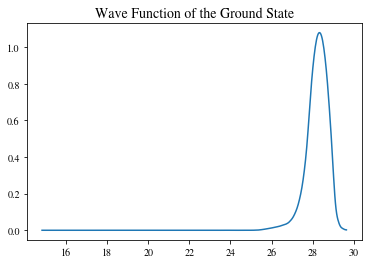

In [48]:
L3 = L

psi_piece = lambda x,energy: np.dot( eigvecs_piece[energy], [basis(x,n,L3) for n in range(1,num_bas_funs_2+1)] )

wave_funs.append(psi_piece)

# x = np.linspace(h,L-h,511)
x = np.linspace(h,L-h,500)

# number of energy level
en = 1
# plot the wave function
plt.plot(x,psi_piece(x,en-1))
_ = plt.title("Wave Function of the Ground State", fontsize=(14))

Plot the energy spectrum and the first 6 wave functions

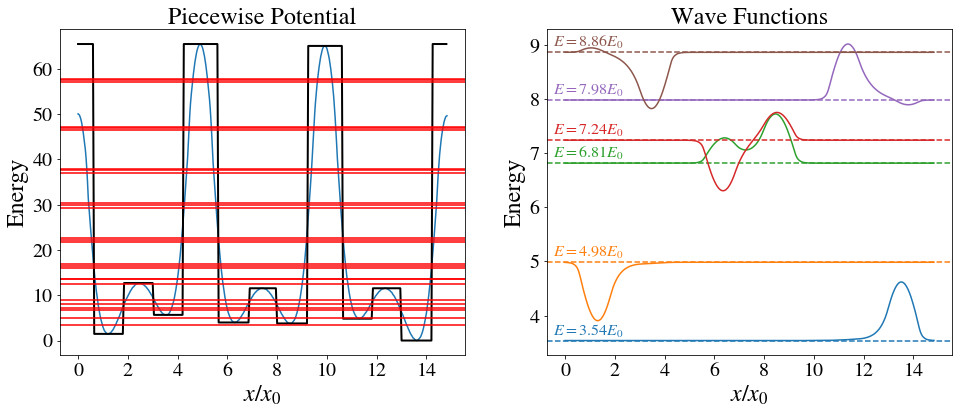

In [49]:
fig3 = plt.figure(figsize=(16,6))

# left plot
plt.subplot(121)

plt.plot(xdata+shift,ydata)
plt.plot(xx,piecewise(xx,Vext_2,Vint_2,widths_2),c='k',linewidth=2.0)
for en in eigvals_piece:
    plt.axhline(en, c='r')
# add title
plt.title('Piecewise Potential',fontsize=24)
# set y-axes labels and ticks size
plt.ylabel("Energy", fontsize = 24)
plt.yticks(fontsize=13)
# set x-axes labels and ticks size
plt.xlabel('$x/x_0$', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# right plot
plt.subplot(122)
# plt.plot(xdata+shift,ydata)

x = np.linspace(h,L-h,500)
# psi = lambda x,energy: np.dot( eigvecs_piece[energy], [basis(x,n,L) for n in range(1,num_bas_fun+1)] )

for i,en in enumerate(eigvals_piece[:6]):
    yplot = psi_piece(x,i)
    curve = plt.plot(x-2*shift, yplot+en)
    col = curve[0].get_color()
    plt.axhline(en, ls="--", c=col)
    plt.text(-0.5, en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)

# pylab.ylim([5,9])

# plt.legend(fontsize=15)
plt.title('Wave Functions', fontsize = 24)
plt.xlabel('$x/x_0$', fontsize = 24)
plt.ylabel("Energy", fontsize = 24)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

# fig3.savefig('piecewise_potential_spectrum.pdf', format='pdf', bbox_inches="tight")

Now, plot all the results in one figure.

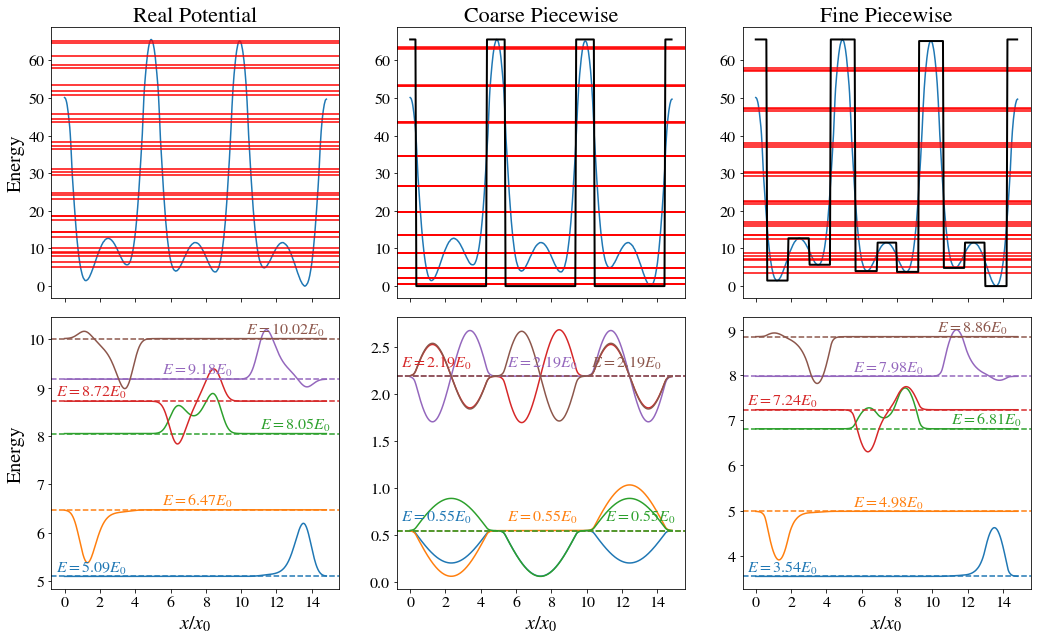

In [58]:
# create figure and axes
fig_all, ax = plt.subplots(2, 3, sharex='col', #sharey='row',
                       figsize=(16,10)
                      )

titles = ['Real Potential', 'Coarse Piecewise', 'Fine Piecewise']
energies = [ eigvals, eigvals_approx, eigvals_piece ]
topology = [[Vext_1,Vint_1,widths_1],[Vext_2,Vint_2,widths_2]]
text_location = [ -0.5, 5.5, 11.05, -0.5, 5.5, 10.25]


# upper series of plots
for i in range(3):
    ax[0,i].plot(xdata+shift,ydata)
    for en in energies[i]:
        ax[0,i].axhline(en, c='r')
    
    # title of the i-th plot 
    ax[0,i].set_title(titles[i], fontsize=22) 

for i in range(1,3):
    ax[0,i].plot(xx,piecewise(xx,topology[i-1][0],topology[i-1][1],topology[i-1][2]),c='k',linewidth=2.0)
    
# lower series of plots 
for i,wf in zip(range(3),wave_funs):
    for j,en in enumerate(energies[i][:6]):
        yplot = wf(x,j)
        curve = ax[1,i].plot(x-2*shift, yplot+en)
        col = curve[0].get_color()
        ax[1,i].axhline(en, ls="--", c=col)
        ax[1,i].text(text_location[j], en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)
#         ax[1,i].text(-0.5, en + 0.1, f"$E = {en:.2f}E_0$", color=col, fontsize=16)


# set y-labels
for i in range(2):
    ax[i,0].set_ylabel("Energy", fontsize = 20)

# change yticks fontisize
for i in range(2):
    for j in range(3):
        plt.sca(ax[i, j])
        plt.yticks( fontsize = 16)

# change xticks fontisize and set x-labels
for i in range(3):
    plt.sca(ax[1, i])
    plt.xlabel('$x/x_0$', fontsize = 20)
    plt.xticks(fontsize = 16)
    
# set the distance between subplots
plt.subplots_adjust(top=0.88, bottom=0.1, left=0.10, right=0.95, hspace=0.07, wspace=0.2)

# fig_all.savefig('table_potential_spectrum.pdf', format='pdf', bbox_inches="tight")